# 4a: discussion CMIP6 projections until 2300 
- creates `Supplementary Fig. 1` with global temperature changes of CMIP6 climate scenarios, which have temperature overshoots until 2300 and respective glacier model projections on three glacier models. We analyse glacier model projections as global aggregates and for three example regions.
     - uses data from Schuster et al., 2023: lilianschuster/glacier-model-projections-until2300: v0.1 Zenodo (https://doi.org/10.5281/zenodo.10059477)

In [1]:
from oggm import utils
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import os
import json
import seaborn as sns
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [2]:
plt.rcParams['figure.dpi'] = 72  # Lower DPI for smaller file size of the jupyter notebook

In [3]:
cmip = 'CMIP6'
endyr = 2300
# path to the glacier model projections until 2300
# also available at  https://doi.org/10.5281/zenodo.10059477
_fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'

In [4]:
pd_clim_all = pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')

In [5]:
model_ls = {'OGGM':'-', 'PyGEM-OGGM':'--','GloGEM':':' }

In [6]:
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   

gcms_ssps = []
for ind in gcms_cmip6.loc[gcms_cmip6['var']=='pr'].index:
    gcms_ssps.append(f'{gcms_cmip6.loc[ind].gcm}_{gcms_cmip6.loc[ind].ssp}')
gcm_c = {}
for e,gcm in enumerate(['CanESM5', 'IPSL-CM6A-LR', 'CESM2-WACCM', 'MRI-ESM2-0', 'ACCESS-CM2', 'ACCESS-ESM1-5']):
    gcm_c[gcm] = f'C{e}'

ssp126 3 climate models with visible overshoot until 2300
CanESM5 overshoot peak temperature vs minimum: $\Delta$T 0.8 °C
MRI-ESM2-0 overshoot peak temperature vs minimum: $\Delta$T 0.7 °C
IPSL-CM6A-LR overshoot peak temperature vs minimum: $\Delta$T 0.6 °C
ssp534-over 4 climate models with visible overshoot until 2300
CESM2-WACCM overshoot peak temperature vs minimum: $\Delta$T 0.2 °C
CanESM5 overshoot peak temperature vs minimum: $\Delta$T 1.6 °C
MRI-ESM2-0 overshoot peak temperature vs minimum: $\Delta$T 1.1 °C
IPSL-CM6A-LR overshoot peak temperature vs minimum: $\Delta$T 1.0 °C


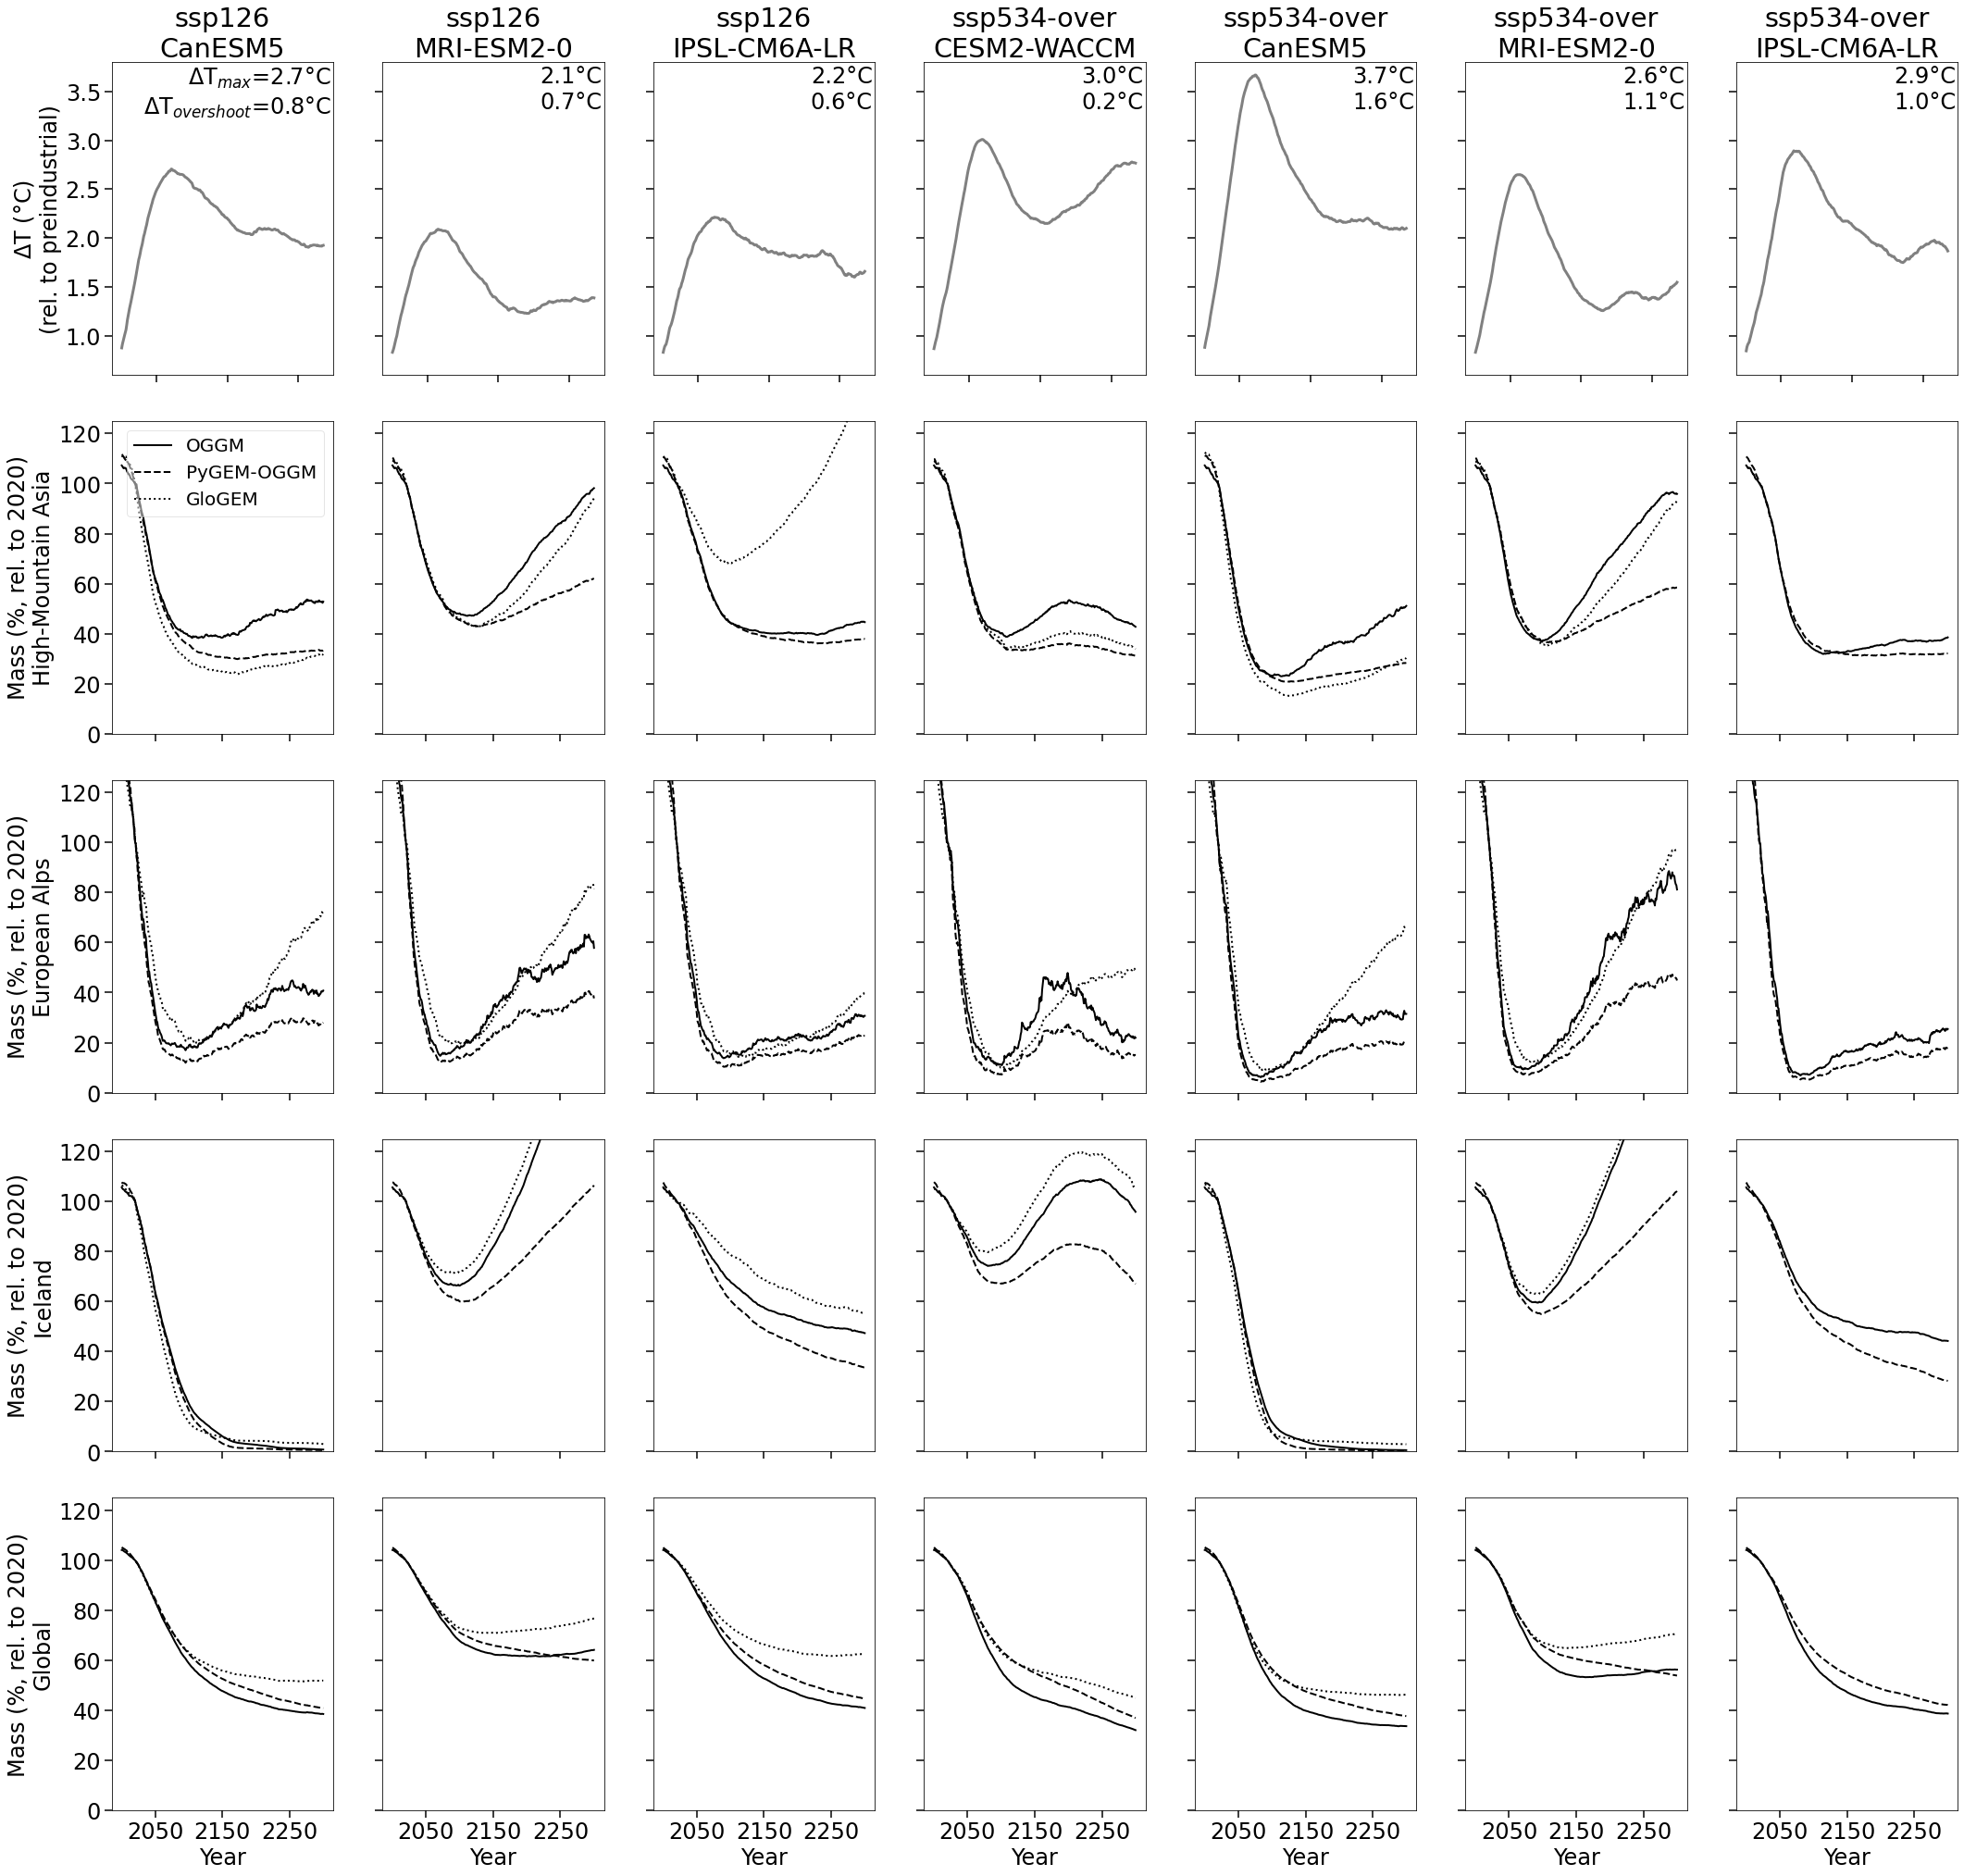

In [17]:

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1


plt.rc('font', size=24)

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(5,7, figsize=(30,28))

#fig,axs = plt.subplots(2,3,figsize=(24,20))
#fig, axs_all = plt.subplots(4,6, figsize=(35,24))

axs = axs_all[0][:3]

# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]

ssp = 'ssp126'
scenario = ssp
gcms_cmip6_2300_ssp = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
gcm_order = [#'CESM2-WACCM', no overshoot
             'CanESM5',
       'MRI-ESM2-0', 
    'IPSL-CM6A-LR',
    #'ACCESS-ESM1-5', 'ACCESS-CM2' ### no overshoot
            ]


gcms_cmip6_2300_ssp.index = gcms_cmip6_2300_ssp.gcm
gcms_cmip6_2300_ssp = gcms_cmip6_2300_ssp.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_ssp) , 'climate models with visible overshoot until 2300')

for ax,f in zip(axs,gcms_cmip6_2300_ssp.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_ssp.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_ssp.loc[f].gcm
    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    if ax == axs[0]:
        ax.set_ylabel(r'$\Delta$T (°C)'+'\n(rel. to preindustrial)')
    ax.set_xlabel('')
    if ax != axs[0]:
        ax.set_yticklabels([])
    ax.set_xticks([2050,2150,2250], ['','',''])

    
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, r'overshoot peak temperature vs minimum: $\Delta$T', overshoot_deg.values.round(1), '°C')
    temp_overshoot_deg = global_dtas.max()- global_dtas.sel(year=slice('2100','2300')).min()
    
    peak_temp = (global_dtas.max()- avg_1986_2005 + 0.69).values.round(1)
    if f==gcms_cmip6_2300_ssp.index[0]:
        ax.text(0.99,0.99,r'$\Delta$T$_{max}$='+f'{peak_temp}°C\n'+r'$\Delta$T$_{overshoot}$='+f'{overshoot_deg.values.round(1)}°C',
                fontsize=24,
               horizontalalignment='right',  # Align text to the right
        verticalalignment='top',      # Align text to the top
        transform=ax.transAxes)
    else:
        ax.text(0.99,0.99,r''+f'{peak_temp}°C\n'+f'{overshoot_deg.values.round(1)}°C',
                fontsize=24,
               horizontalalignment='right',  # Align text to the right
        verticalalignment='top',      # Align text to the top
        transform=ax.transAxes)
for region in ['global', 'RGI13-14-15', 'RGI11', 'RGI06']:
    if region == 'global':
        axs = axs_all[4][:3]
    elif region == 'RGI06':
        axs = axs_all[3][:3]
    elif region == 'RGI13-14-15':
        axs = axs_all[1][:3]
    elif region == 'RGI11':
        axs = axs_all[2][:3]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        for gcm,ax in zip(gcm_order,axs):
            ax.plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300][gcm.upper()]/pd_cmip_scen.loc[2020][gcm.upper()],
                     ls = model_ls[model], color='black',
                     label=model, lw=2)
        if region == 'RGI13-14-15':
            axs[0].legend(fontsize=20, framealpha = 0.5)
        if region == 'global':
            region_n = 'Global'
        elif region == 'RGI13-14-15':
            region_n = 'High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'European Alps'
        elif region == 'RGI06':
            region_n = 'Iceland'
            
        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel(f'Mass (%, rel. to 2020)\n{region_n}')
            ax.set_xlabel('')
            ax.set_ylim([0,125])
            if ax != axs[0]:
                ax.set_yticklabels([])
            ax.set_xticks([2050,2150,2250], ['','',''])
    

##############################################
axs = axs_all[0][3:]
ssp = 'ssp534-over'
scenario = ssp

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcms_cmip6_2300_over.index = gcms_cmip6_2300_over.gcm
gcms_cmip6_2300_over = gcms_cmip6_2300_over.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_over), 'climate models with visible overshoot until 2300')

for ax,f in zip(axs,gcms_cmip6_2300_over.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_over.loc[f].gcm
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, r'overshoot peak temperature vs minimum: $\Delta$T', overshoot_deg.values.round(1), '°C')
    temp_overshoot_deg = global_dtas.max()- global_dtas.sel(year=slice('2100','2300')).min()

    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    ax.set_yticklabels([])
    ax.set_xticks([2050,2150,2250], ['','',''])
    ax.set_xlabel('')
    peak_temp = (global_dtas.max()- avg_1986_2005 + 0.69).values.round(1)
    ax.text(0.99,0.99,r''+f'{peak_temp}°C\n'+f'{overshoot_deg.values.round(1)}°C',
            fontsize=24,
           horizontalalignment='right',  # Align text to the right
    verticalalignment='top',      # Align text to the top
    transform=ax.transAxes)


for region in ['RGI13-14-15', 'RGI11', 'RGI06', 'global']:
    if region == 'global':
        axs = axs_all[4][3:]
    elif region == 'RGI13-14-15':
        axs = axs_all[1][3:]
    elif region == 'RGI06':
        axs = axs_all[3][3:]
    elif region == 'RGI11':
        axs = axs_all[2][3:]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        axs[0].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CESM2-WACCM']/pd_cmip_scen.loc[2020]['CESM2-WACCM'], ls = model_ls[model], color='black',
                   label=model, lw=2)
        axs[1].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CANESM5']/pd_cmip_scen.loc[2020]['CANESM5'], ls = model_ls[model], color='black',
                   lw=2)
        axs[2].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['MRI-ESM2-0']/pd_cmip_scen.loc[2020]['MRI-ESM2-0'], ls = model_ls[model], color='black',
                   lw=2)
        if model != 'GloGEM':
            axs[3].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['IPSL-CM6A-LR']/pd_cmip_scen.loc[2020]['IPSL-CM6A-LR'], ls = model_ls[model], color='black', 
                       lw=2)
        if region == 'global':
            region_n = 'Global'
        elif region == 'RGI13-14-15':
            region_n = 'High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'European Alps'
        elif region == 'RGI06':
            region_n = 'Iceland'

        for ax in axs:
            ax.set_xlabel('')
            ax.set_ylim([0,125])
            #if ax != axs[0]:
            ax.set_yticklabels([])
            ax.set_xticks([2050,2150,2250], ['','',''])

plt.tight_layout()
for ax in axs_all[4]:
    ax.set_xlabel('Year')
    ax.set_xticks([2050,2150,2250], [2050,2150,2250])

plt.savefig('../figures/suppl_fig_4_discussion_cmip6_overshoot_gcms_ssp126_ssp534_over_2300.png', dpi=300)
plt.savefig('../figures/suppl_fig_4_discussion_cmip6_overshoot_gcms_ssp126_ssp534_over_2300.pdf', dpi=300)

**Check strange GloGEM IPSL behavior**

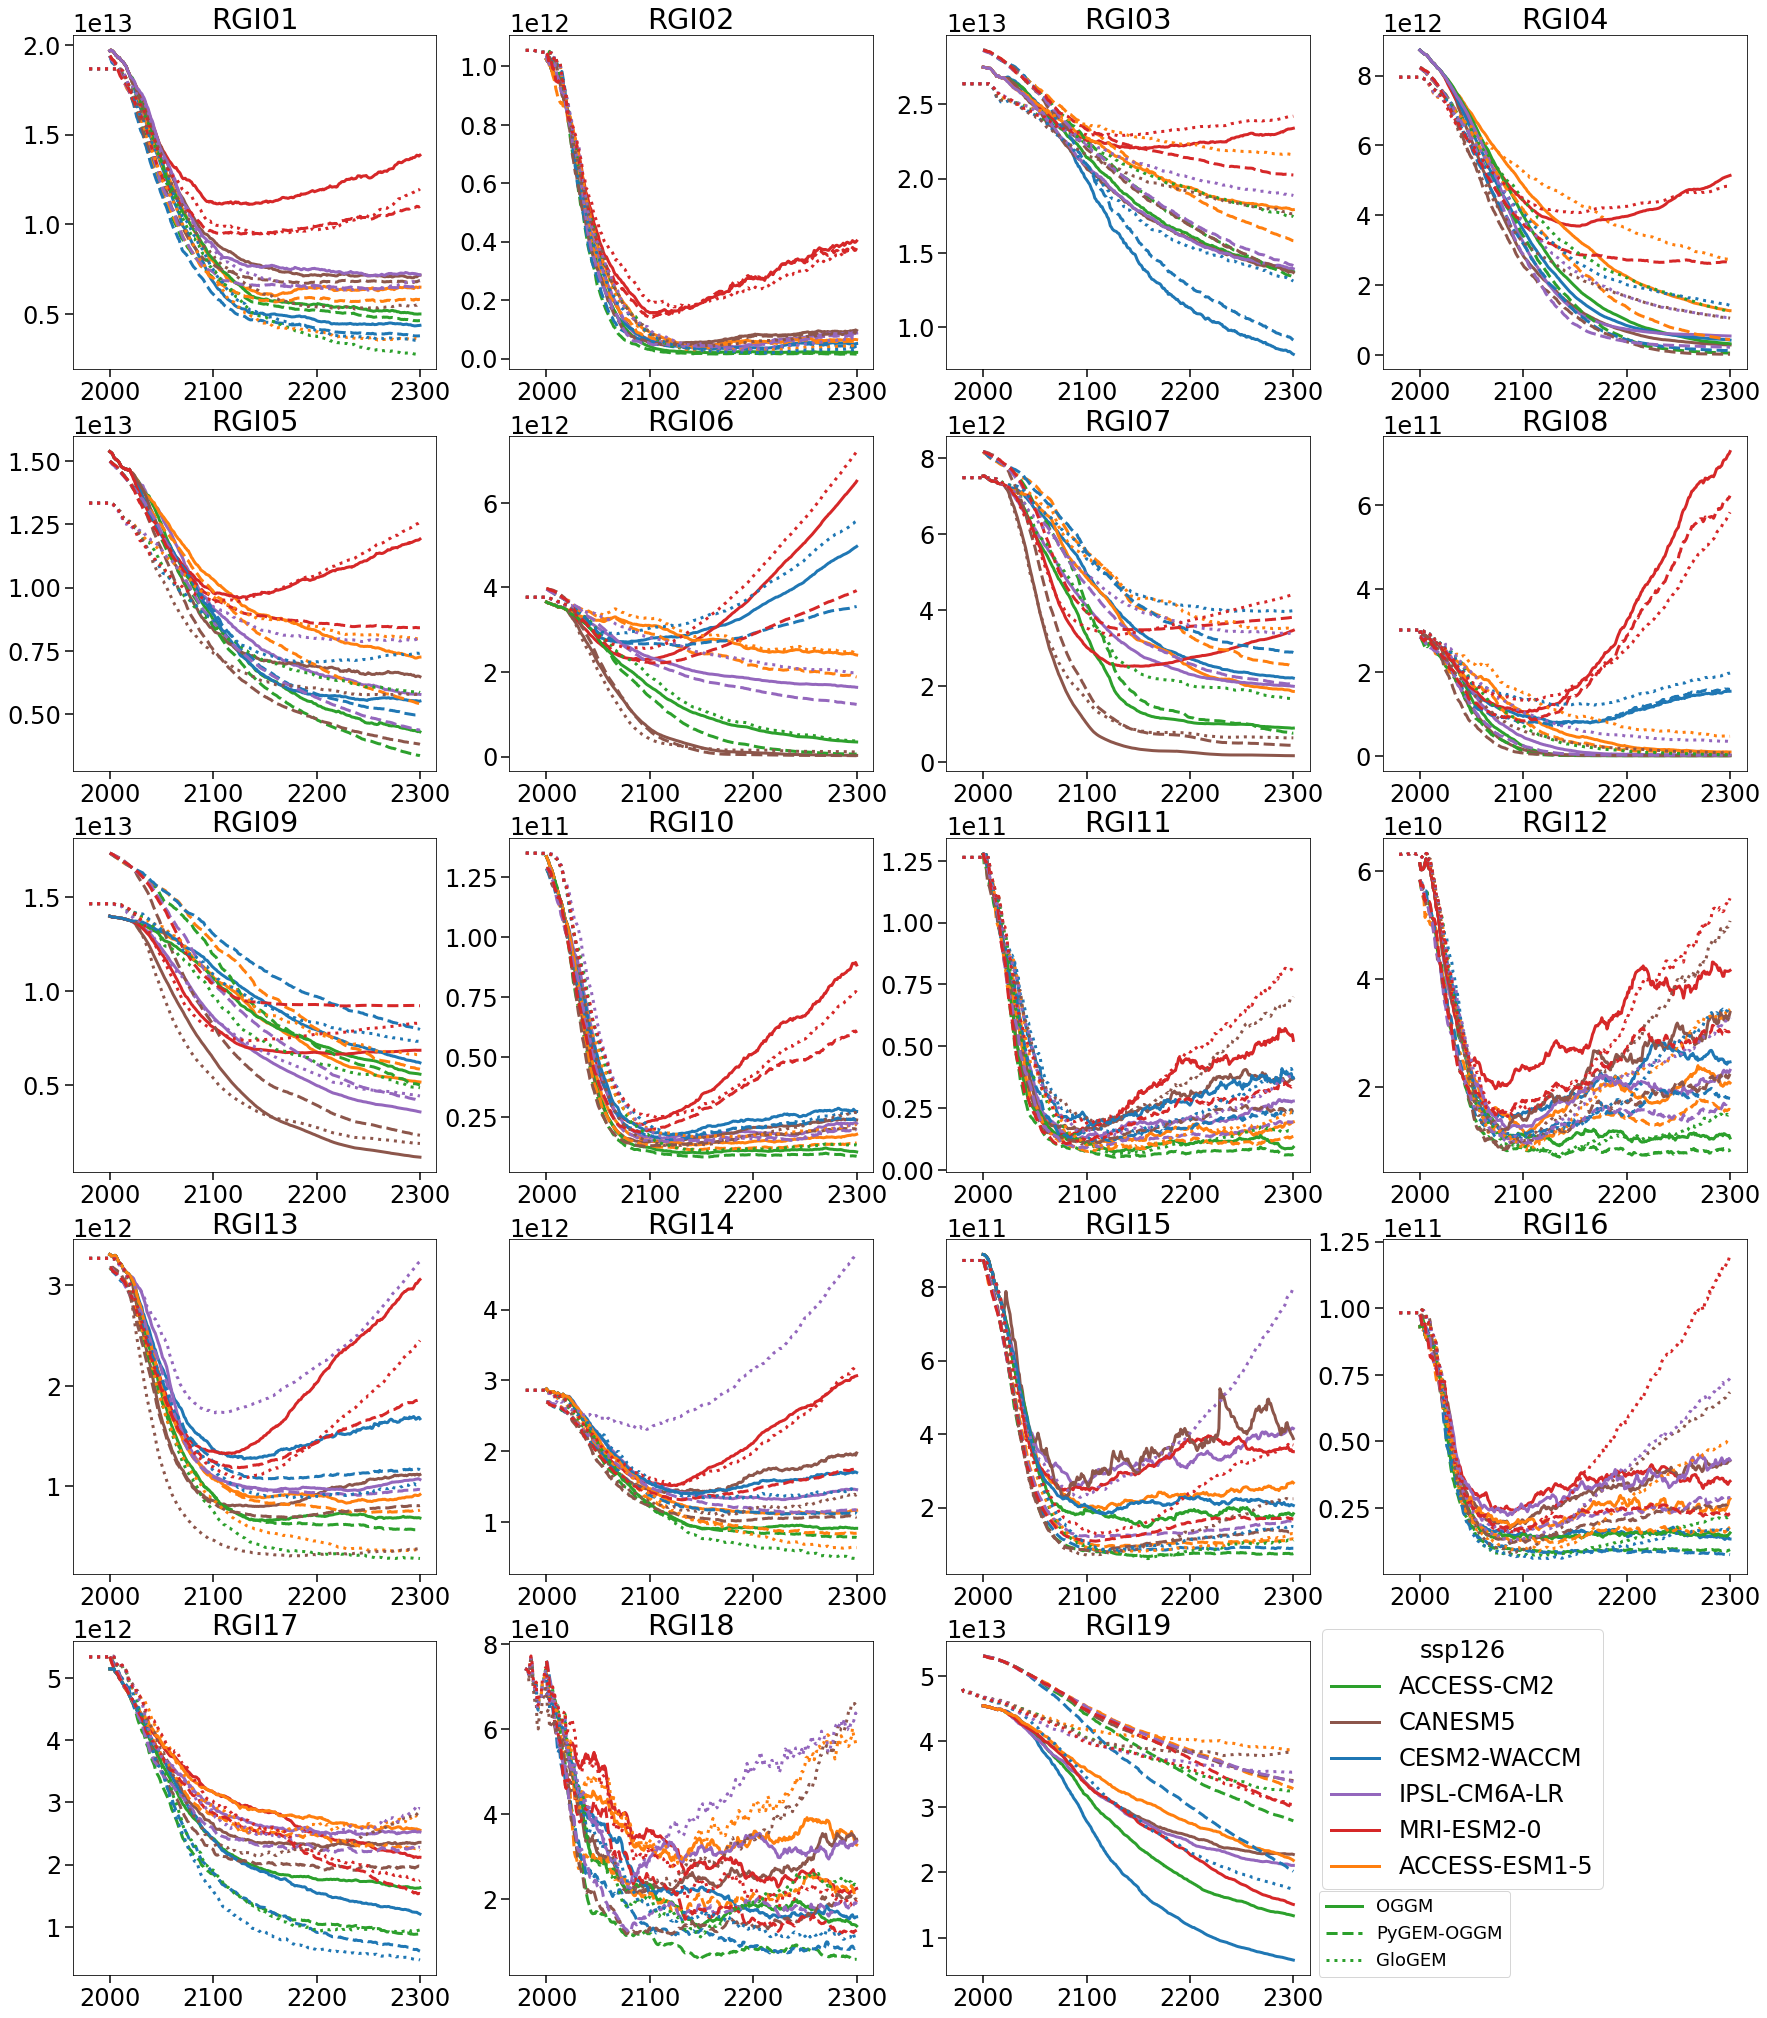

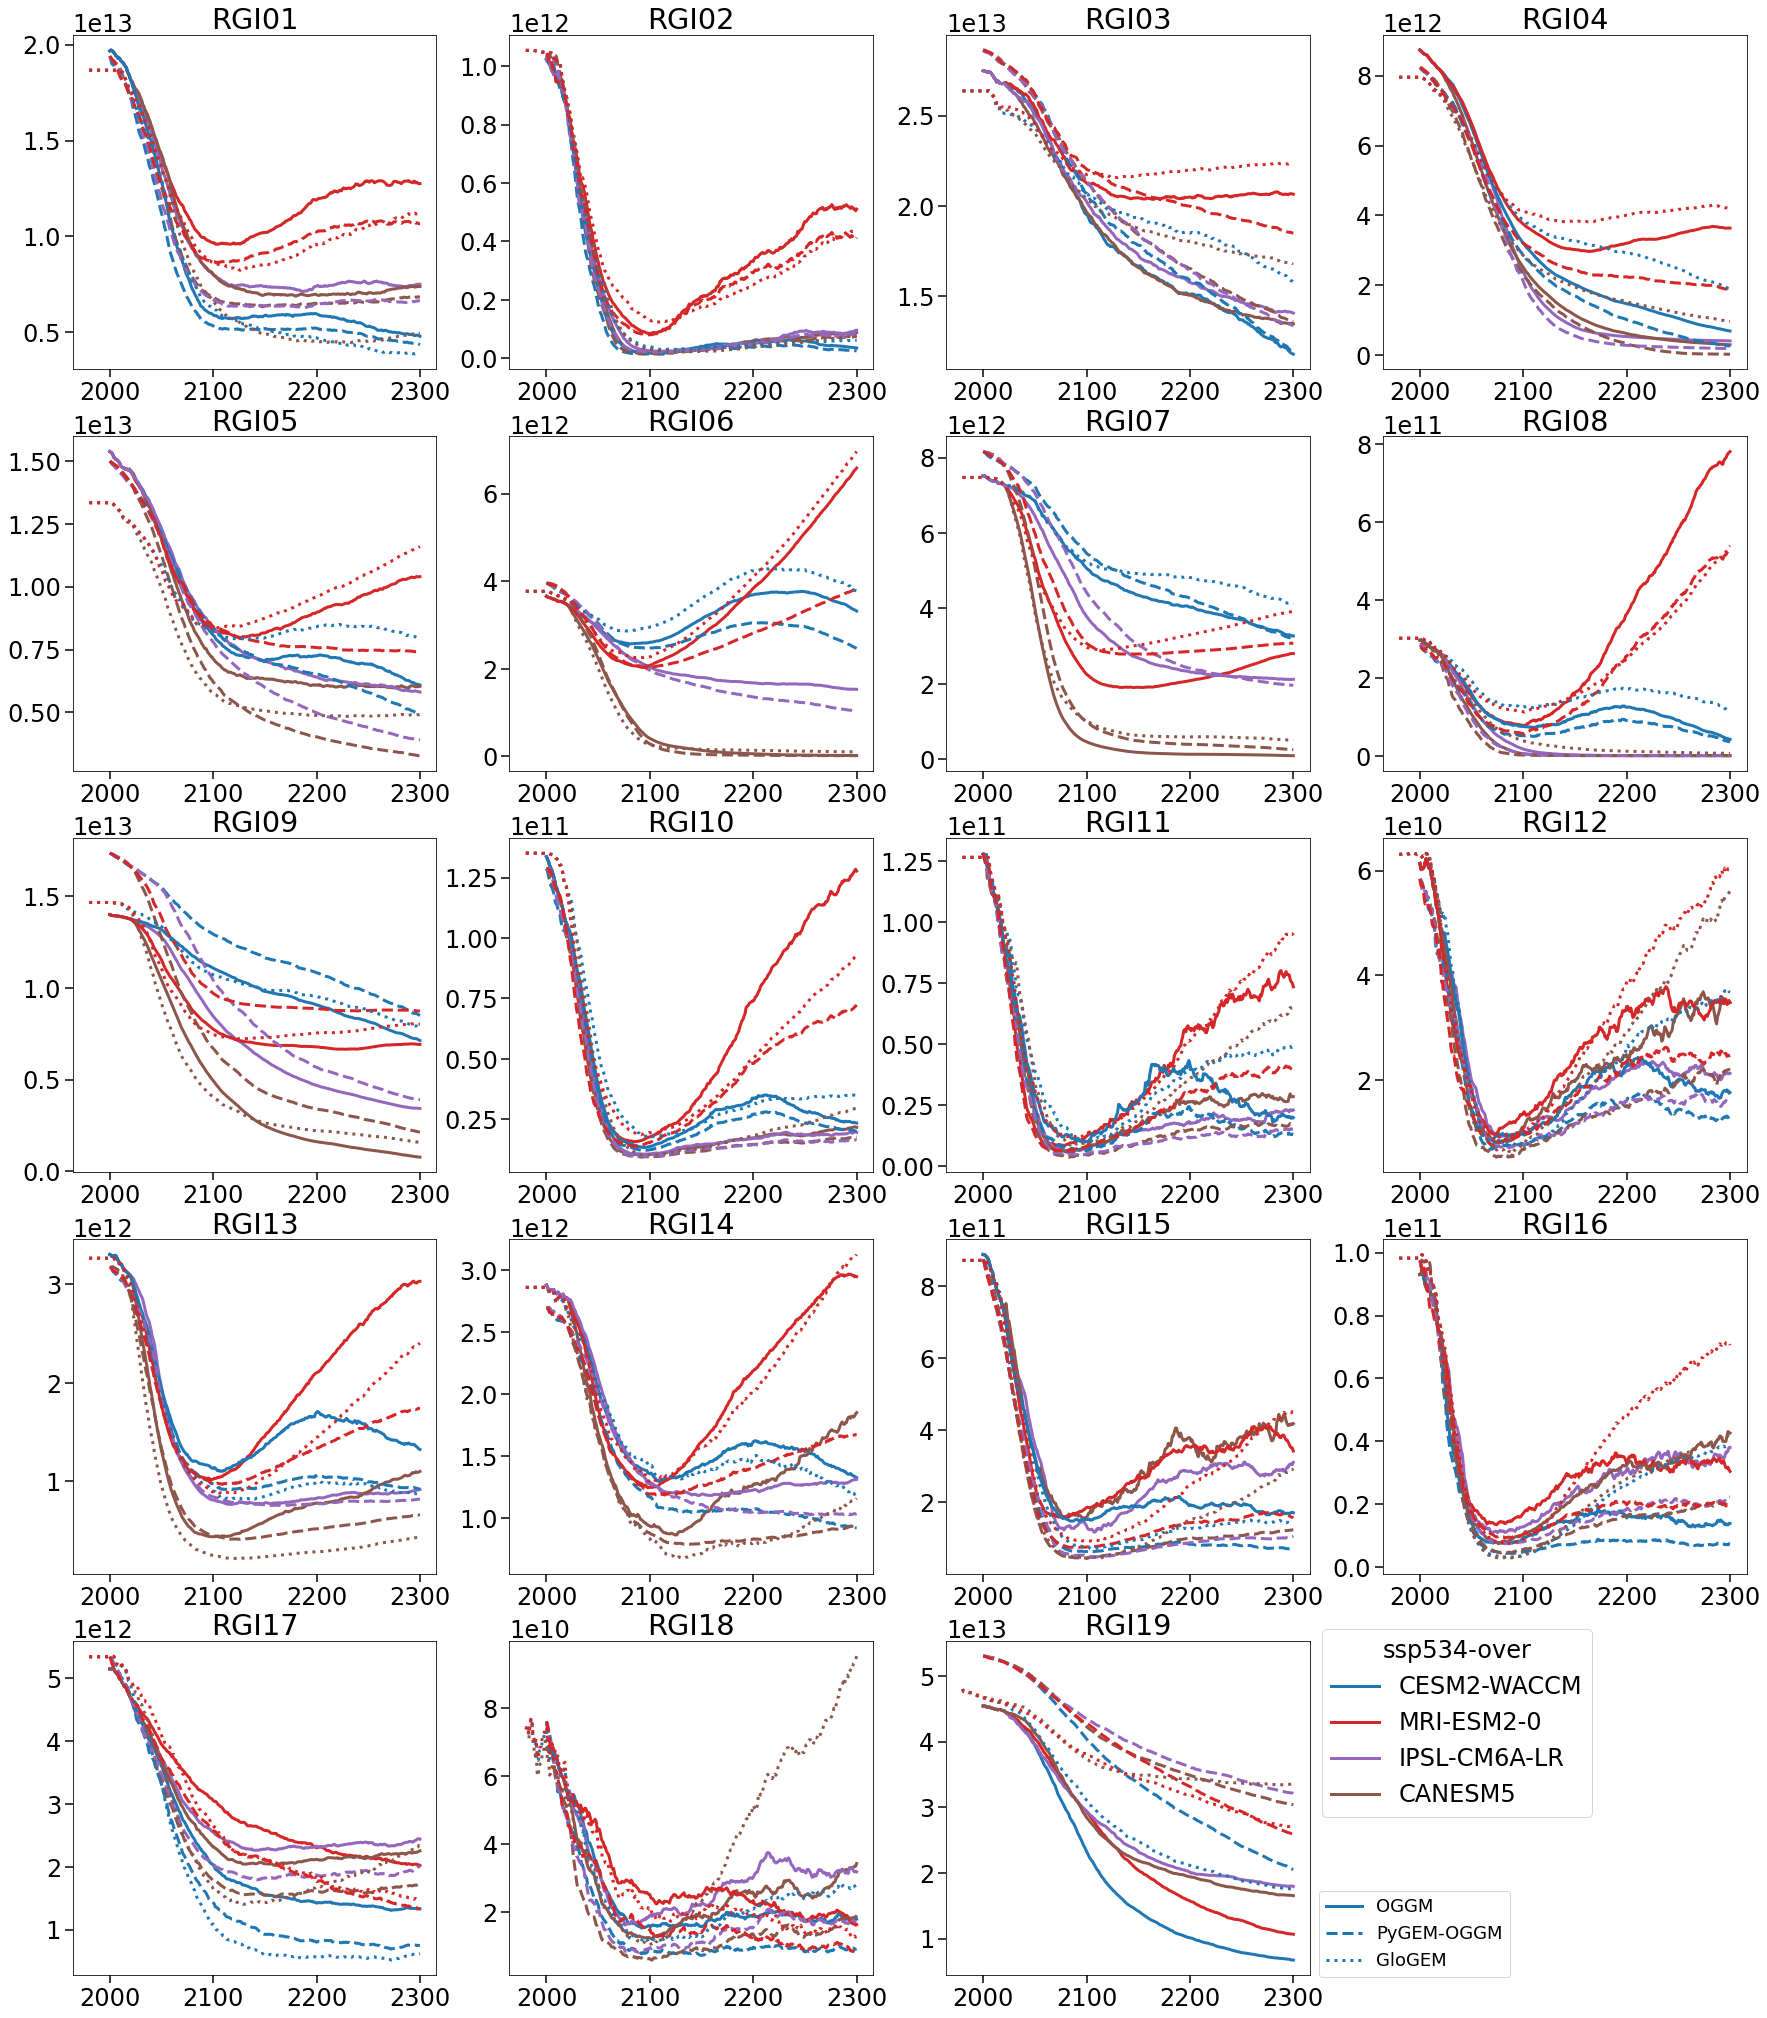

In [8]:
## these are the ssp126 scenarios 
colors_gcm_d = {}
for jj,g in enumerate(['CESM2-WACCM', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MRI-ESM2-0',  'IPSL-CM6A-LR','CANESM5']):
    colors_gcm_d[g] = f'C{jj}'
gcm_ssp_534_over = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']

for scenario in ['ssp126', 'ssp534-over']:
    if scenario =='ssp126':
        gcms = list(colors_gcm_d.keys())
    else:
        gcms  = gcm_ssp_534_over
    plt.figure(figsize=(30,35))
    j = 1
    for region in ['RGI01','RGI02', 'RGI03',
                   'RGI04','RGI05', 'RGI06',
                   'RGI07','RGI08', 'RGI09',
                   'RGI10','RGI11', 'RGI12',
                   'RGI13','RGI14', 'RGI15',
                  'RGI16','RGI17', 'RGI18','RGI19']:
        plt.subplot(5,4,j)

        for model in ['OGGM','PyGEM-OGGM','GloGEM']:
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()

            _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]

            for gcm in pd_cmip_scen.columns:
                plt.plot(pd_cmip_scen.index, pd_cmip_scen[gcm], label=gcm, lw = 3, ls = model_ls[model], color=colors_gcm_d[gcm.upper()])
        j +=1
        plt.title(region)
        if region == 'RGI19':
            handles, labels = plt.gca().get_legend_handles_labels()
            leg = plt.legend(handles[:len(gcms)], labels[:len(gcms)], 
                       bbox_to_anchor=(1,1.07), loc= 'upper left', title=f'{scenario}')
            plt.legend(handles[::len(gcms)],  ['OGGM','PyGEM-OGGM','GloGEM'], bbox_to_anchor=(1,0.28), loc = 'upper left', fontsize=18)
            plt.gca().add_artist(leg)
    #plt.tight_layout()
    # plt.savefig(f'figures/4_busy_plot_all_regions_{scenario}_allmodels.png')

#### Some other figure variants - not used in manuscript

#### Absolute values graph ... 

ssp534-over 4


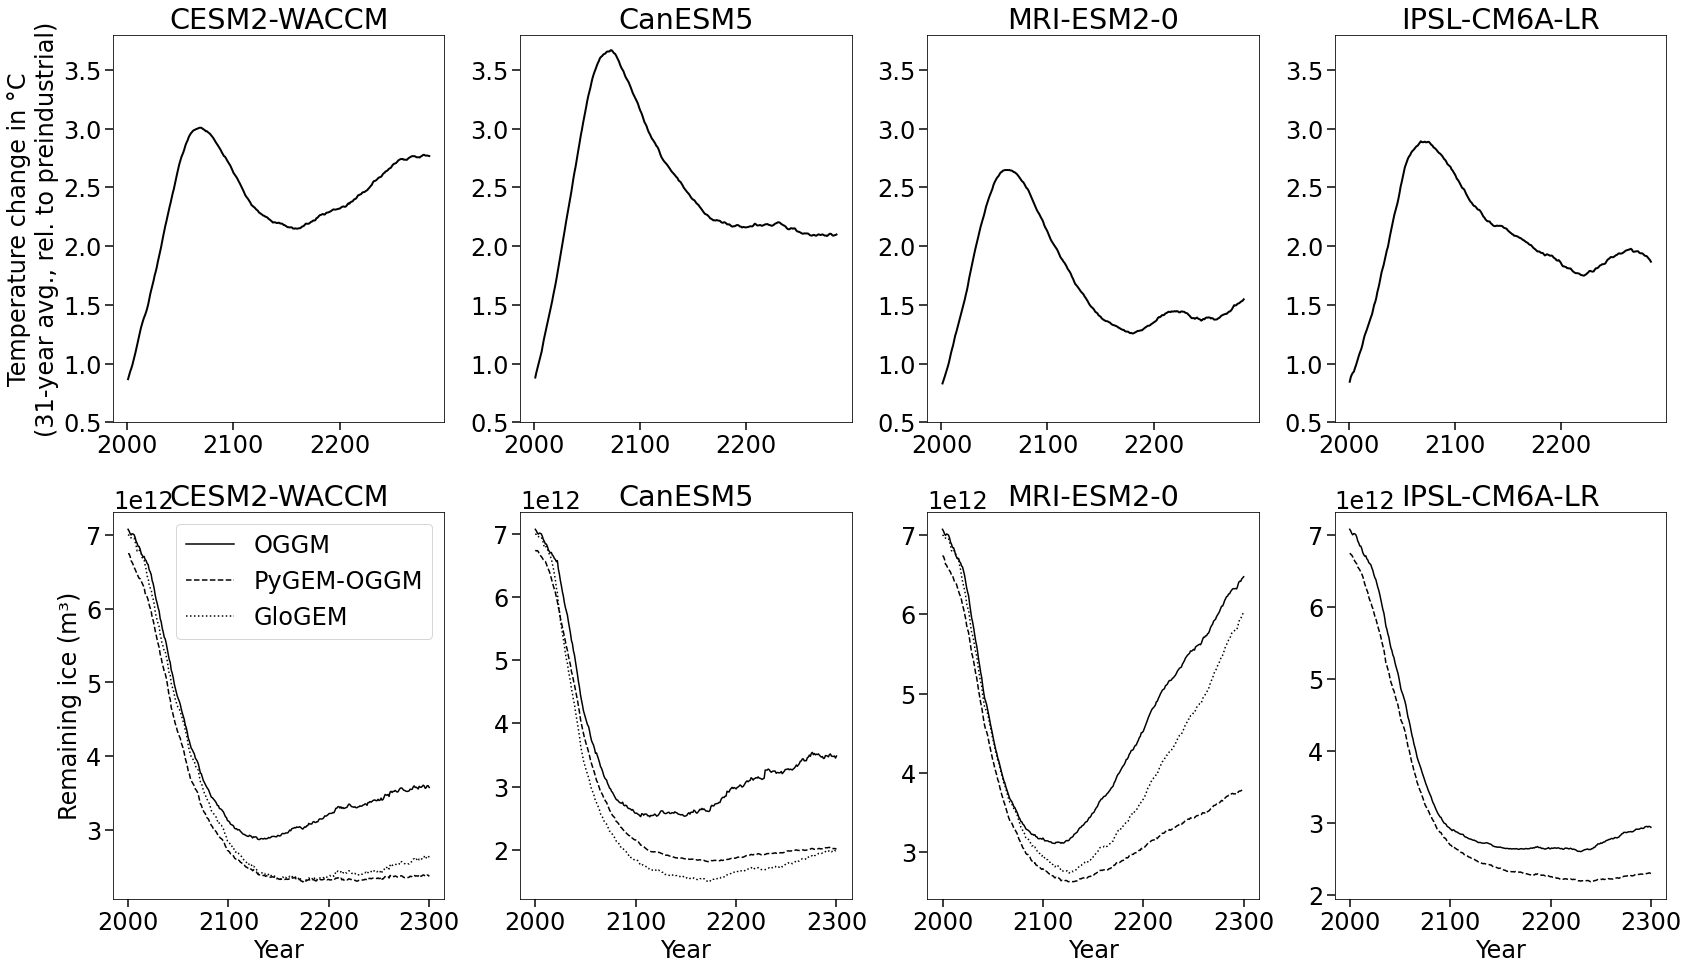

In [11]:

from matplotlib.lines import Line2D

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(2,4, figsize=(24,14))

axs = axs_all[0]
plt.rc('font', size=24)
ssp = 'ssp534-over'
# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcms_cmip6_2300_over.index = gcms_cmip6_2300_over.gcm
gcms_cmip6_2300_over = gcms_cmip6_2300_over.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_over))

for ax,f in zip(axs,gcms_cmip6_2300_over.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, lw=2,
            color= 'black')
    gcm = gcms_cmip6_2300_over.loc[f].gcm
    ax.set_title(gcm)
    ax.set_ylim([0.5,3.8])
    if ax == axs[0]:
        ax.set_ylabel('Temperature change in °C\n(31-year avg., rel. to preindustrial)')
for region in ['RGI13-14-15']:
    if region == 'global':
        axs = axs_all[2]
    else:
        axs = axs_all[1]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
            pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]

        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        axs[0].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['CESM2-WACCM'], ls = model_ls[model], color='black',
                   label=model)
        axs[0].set_title('CESM2-WACCM')
        axs[1].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['CANESM5'], ls = model_ls[model], color='black')
        axs[1].set_title('CanESM5')
        axs[2].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['MRI-ESM2-0'], ls = model_ls[model], color='black')
        axs[2].set_title('MRI-ESM2-0')
        if model != 'GloGEM':
            axs[3].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['IPSL-CM6A-LR'], ls = model_ls[model], color='black')
            axs[3].set_title('IPSL-CM6A-LR')
        axs[0].legend()
        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel('Remaining ice (m³)')
            ax.set_xlabel('Year')
            #ax.set_ylim([0,135])

plt.tight_layout()